<a href="https://colab.research.google.com/github/PanasRojpattanadecha/bsc_dpdm24/blob/main/midterm_dpdm24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

# 1 เตรียมข้อมูลเพื่อทำนายราคาบ้าน (15 คะแนน)
เตรียมข้อมูลเพื่อทำนายราคาบ้านมือสอง ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price', 'district', 	'sub_district', 'zone'``` จากไฟล์ "Data House" - บ้านมือ 2 (5 คะแนน)

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 1 กิโลเมตร (ตั้งชื่อ 'd1000-7/11' และ 'd1000-school')``` จากไฟล์ "7-eleven.json" และ "school.json" โดยคำนวณจากพิกัด latitute longitude ระหว่างบ้าน และ  7-11 หรือ โรงเรียน ใกล้เคียงของบ้านแต่ละ id ในไฟล์ json (id บ้านหลังไหนที่มีมีข้อมูลแปลว่าไม่มี 7-11 หรือ โรงเรียนอยู่ในรัศมี 5 กิโลเมตร) (7 คะแนน)

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากไฟล์ "คำตอบนักประเมิน(ID)" - บ้าน โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว (3 คะแนน)

# 2 จากตารางในข้อ 1 ตอบคำถามต่อไปนี้ (5 คะแนน)
1. zone ใดมีราคาซื้อขายบ้าน 'sell price' เฉลี่ยสูงที่สุด (1 คะแนน)
2. บ้านที่มีจำนวน 7-11 อยู่ในรัศมี 1 กิโลเมตรมากที่สุด ราคาเท่าไหร่ (2 คะแนน)
3. ตำบล (sub_district) ไหน ได้คะแนนทรัพย์ 'score' เฉลี่ยจากนักประเมินมากที่สุด (2 คะแนน)

# 1 เตรียมข้อมูลเพื่อทำนายราคาบ้าน (15 คะแนน)

In [501]:
import pandas as pd
import numpy as np
import json
from math import radians, sin, cos, sqrt, atan2
from google.colab import drive

In [502]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [503]:
# File paths
data_house_path = '/content/drive/My Drive/MIDterm/Data House.xlsx'
seven_eleven_path = '/content/drive/My Drive/MIDterm/7-eleven.json'
school_path = '/content/drive/My Drive/MIDterm/school.json'
estimator_path = '/content/drive/My Drive/MIDterm/คำตอบนักประเมิน(ID).xlsx'

In [504]:
# Load "Data House" file
data_house = pd.read_excel(data_house_path)

In [505]:
data_house = data_house[['id', 'renovate', 'number_of_rai', 'number_of_ngan', 'number_of_va',
                         'number_of_story', 'number_of_bedroom', 'number_of_bathroom', 'direction',
                         'furniture', 'usable_area', 'number_of_parking', 'sell_price',
                         'district', 'sub_district', 'zone', 'latitude', 'longitude']]

In [506]:
data_house = data_house.dropna(subset=['latitude', 'longitude', 'sell_price'])

In [528]:
# Load 7-eleven and school data
with open(seven_eleven_path, 'r') as f:
    seven_eleven = json.load(f)

with open(school_path, 'r') as f:
    school = json.load(f)

In [508]:
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [509]:
def count_within_radius(house_lat, house_lon, locations, radius_km=1):
    if np.isnan(house_lat) or np.isnan(house_lon):
        return 0
    count = 0
    for location in locations:
        try:
            distance = calculate_distance(house_lat, house_lon, location['latitude'], location['longitude'])
            print(f"House: {house_lat}, {house_lon} -> 7-11/school: {location['latitude']}, {location['longitude']} | Distance: {distance} km")
            if distance <= radius_km:
                count += 1
        except KeyError:
            continue
    return count


In [510]:
seven_eleven_locations = [{'latitude': float(loc['latitude']), 'longitude': float(loc['longitude'])}
                          for loc in seven_eleven if 'latitude' in loc and 'longitude' in loc]

In [511]:
school_locations = [{'latitude': float(loc['latitude']), 'longitude': float(loc['longitude'])}
                    for loc in school if 'latitude' in loc and 'longitude' in loc]

In [512]:
data_house['d1000-7/11'] = data_house.apply(
    lambda row: count_within_radius(row['latitude'], row['longitude'], seven_eleven_locations), axis=1)

data_house['d1000-school'] = data_house.apply(
    lambda row: count_within_radius(row['latitude'], row['longitude'], school_locations), axis=1)

In [513]:
# Load "คำตอบนักประเมิน(ID)" file
estimator_data = pd.read_excel(estimator_path)

In [514]:
# ฟังก์ชันการทำความสะอาดค่าที่เป็น 'str' ที่มีตัวอักษรเช่น P
def clean_numeric_value(value):
    if isinstance(value, str):
        # ตรวจสอบว่ามีตัวอักษรหรือไม่และลบออก
        cleaned_value = ''.join(filter(str.isdigit, value))
        if cleaned_value:
            return int(cleaned_value)
        else:
            return np.nan
    elif isinstance(value, (int, float)):
        return value
    return np.nan

In [515]:
estimator_data = estimator_data.rename(columns={'ให้คะแนนทรัพย์': 'score'})

estimator_data['score'] = estimator_data['score'].apply(lambda x: int(str(x).split()[0]) if isinstance(x, str) and x.split()[0].isdigit() else np.nan)


In [516]:
print(estimator_data.columns)

estimator_data = estimator_data.rename(columns={'ID': 'id', 'ให้คะแนนทรัพย์': 'score'})
print(estimator_data[['id', 'score']].head())


Index(['ID ผู้ประเมิน', 'post id', 'ID', 'property_type',
       'ความมั่นใจในการเมินราคาทรัพย์', 'ราคาทรัพย์', 'ประเมินราคาซื้อ-ขาย',
       'ปัจจัยในการประเมินราคาซื้อ-ขาย', 'เหตุผลไม่มั่นใจราคาประเมิน',
       'score'],
      dtype='object')
    id  score
0   25    3.0
1   25    4.0
2   33    2.0
3   33    3.0
4  495    3.0


In [517]:
estimator_data = estimator_data.rename(columns={'ID': 'id', 'ให้คะแนนทรัพย์': 'score'})

In [518]:
final_data = pd.merge(data_house, estimator_data, on='id', how='left')
final_data = final_data.dropna(subset=['score'])
final_data = final_data.drop(columns=['latitude', 'longitude'])

In [519]:
print(final_data.head())

# Save the final dataset
final_data_path = '/content/drive/My Drive/MIDterm/final_data.csv'
final_data.to_csv(final_data_path, index=False)
print(f"Final data saved to {final_data_path}, containing {len(final_data)} rows.")

   id renovate  number_of_rai  number_of_ngan  number_of_va  number_of_story  \
0   1       no              0               1          45.0              2.0   
1   1       no              0               1          45.0              2.0   
2   4       no              0               0          88.0              1.0   
3   4       no              0               0          88.0              1.0   
4  16       no              1               0           8.0              1.0   

   number_of_bedroom  number_of_bathroom direction furniture  ...  \
0                2.0                   2   ไม่ระบุ     ไม่มี  ...   
1                2.0                   2   ไม่ระบุ     ไม่มี  ...   
2                1.0                   1   ไม่ระบุ     ไม่มี  ...   
3                1.0                   1   ไม่ระบุ     ไม่มี  ...   
4               11.0                  11   ไม่ระบุ   ไม่ระบุ  ...   

   d1000-school  ID ผู้ประเมิน                             post id  \
0             0            1.0   h

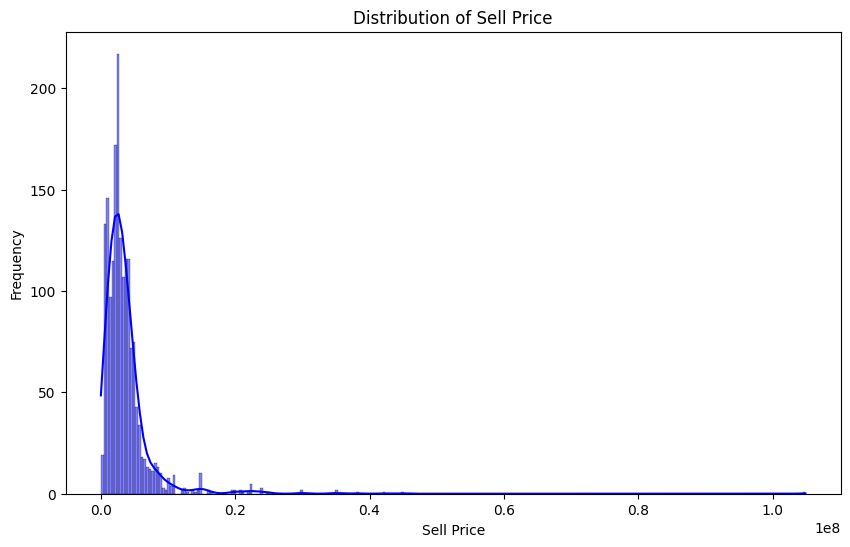

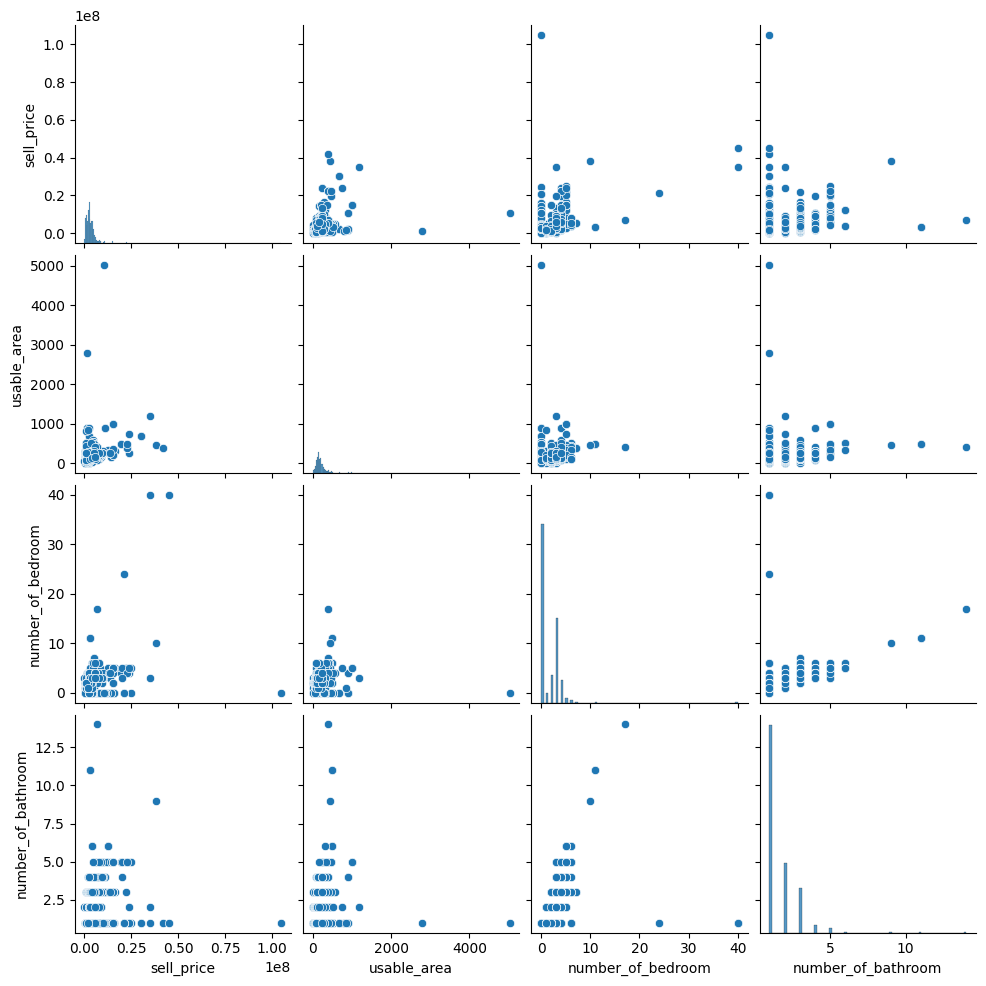

In [520]:
import matplotlib.pyplot as plt
import seaborn as sns

# ดูการกระจายของราคาบ้าน
plt.figure(figsize=(10, 6))
sns.histplot(final_data['sell_price'], kde=True, color='blue')
plt.title('Distribution of Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Frequency')
plt.show()

# ดูความสัมพันธ์ระหว่าง Sell Price กับบางคุณลักษณะ
sns.pairplot(final_data[['sell_price', 'usable_area', 'number_of_bedroom', 'number_of_bathroom']])
plt.show()


In [521]:
# แปลงค่าที่เป็น categorical เป็น numerical
final_data['direction'] = final_data['direction'].astype('category').cat.codes
final_data['furniture'] = final_data['furniture'].astype('category').cat.codes



In [522]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [523]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['renovate', 'district', 'sub_district', 'zone']
for col in categorical_cols:
    le = LabelEncoder()
    final_data[col] = le.fit_transform(final_data[col])

# แยกตัวแปรอิสระ (X) และเป้าหมาย (y)
X = final_data[['renovate', 'number_of_rai', 'number_of_ngan', 'number_of_va', 'number_of_story',
                'number_of_bedroom', 'number_of_bathroom', 'direction', 'furniture', 'usable_area',
                'number_of_parking', 'd1000-7/11', 'd1000-school', 'district', 'sub_district', 'zone']]
y = final_data['sell_price']

In [524]:
new_house_data = {
    'renovate': 0,
    'number_of_rai': 1,
    'number_of_ngan': 2,
    'number_of_va': 3,
    'number_of_story': 2,
    'number_of_bedroom': 3,
    'number_of_bathroom': 2,
    'direction': 0,
    'furniture': 1,
    'usable_area': 150,
    'number_of_parking': 2,
    'd1000-7/11': 3,
    'd1000-school': 1,
    'district': 'District1',
    'sub_district': 'SubDistrict1',
    'zone': 'Zone1'
}

# สร้าง DataFrame สำหรับบ้านใหม่
new_house_df = pd.DataFrame([new_house_data])

# Import RandomForestRegressor and train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

categorical_cols = ['renovate', 'district', 'sub_district', 'zone']
for col in categorical_cols:
    combined_values = list(final_data[col].unique()) + list(new_house_df[col].unique())
    le.fit(combined_values)
    final_data[col] = le.transform(final_data[col])
    new_house_df[col] = le.transform(new_house_df[col])


X = final_data[['renovate', 'number_of_rai', 'number_of_ngan', 'number_of_va', 'number_of_story',
                'number_of_bedroom', 'number_of_bathroom', 'direction', 'furniture', 'usable_area',
                'number_of_parking', 'd1000-7/11', 'd1000-school', 'district', 'sub_district', 'zone']]
y = final_data['sell_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ทำนายราคาบ้านใหม่
new_house_price = model.predict(new_house_df)
print(f"Predicted Price: {new_house_price[0]}")

Predicted Price: 3666040.0


# 2 จากตารางในข้อ 1 ตอบคำถามต่อไปนี้ (5 คะแนน)
1. zone ใดมีราคาซื้อขายบ้าน 'sell price' เฉลี่ยสูงที่สุด (1 คะแนน)
2. บ้านที่มีจำนวน 7-11 อยู่ในรัศมี 1 กิโลเมตรมากที่สุด ราคาเท่าไหร่ (2 คะแนน)
3. ตำบล (sub_district) ไหน ได้คะแนนทรัพย์ 'score' เฉลี่ยจากนักประเมินมากที่สุด (2 คะแนน)

# 1. zone ใดมีราคาซื้อขายบ้าน 'sell price' เฉลี่ยสูงที่สุด (1 คะแนน)

In [525]:
# คำนวณราคาซื้อขายเฉลี่ยตาม zone
average_price_by_zone = data_house.groupby('zone')['sell_price'].mean()
highest_price_zone = average_price_by_zone.idxmax()
highest_price = average_price_by_zone.max()
print(f"Zone ที่มีราคาซื้อขายบ้านเฉลี่ยสูงที่สุดคือ: {highest_price_zone} โดยมีราคาซื้อขายเฉลี่ยเท่ากับ {highest_price:.2f}")

Zone ที่มีราคาซื้อขายบ้านเฉลี่ยสูงที่สุดคือ: ในเมือง-รื่นรมย์-เทพารักษ์ โดยมีราคาซื้อขายเฉลี่ยเท่ากับ 7201666.67


# 2. บ้านที่มีจำนวน 7-11 อยู่ในรัศมี 1 กิโลเมตรมากที่สุด ราคาเท่าไหร่ (2 คะแนน)

In [526]:
# Find the house with the maximum number of 7-11s within 1km
max_711_house = final_data['d1000-7/11'].max()
house_with_max_711 = final_data[final_data['d1000-7/11'] == max_711_house]
price_of_max_711_house = house_with_max_711['sell_price'].iloc[0]

print(f"บ้านที่มีจำนวน 7-11 อยู่ในรัศมี 1 กิโลเมตรมากที่สุด มีจำนวน {max_711_house} แห่ง ราคา {price_of_max_711_house:.2f}")

บ้านที่มีจำนวน 7-11 อยู่ในรัศมี 1 กิโลเมตรมากที่สุด มีจำนวน 0 แห่ง ราคา 390000.00


# 3. ตำบล (sub_district) ไหน ได้คะแนนทรัพย์ 'score' เฉลี่ยจากนักประเมินมากที่สุด (2 คะแนน)

In [527]:
# ตำบลที่ได้คะแนนทรัพย์เฉลี่ยสูงที่สุด
highest_avg_sub_district = final_data.groupby('sub_district')['score'].mean().idxmax()
highest_avg_score = final_data.groupby('sub_district')['score'].mean().max()

print(f"ตำบลที่ได้คะแนนทรัพย์เฉลี่ยสูงที่สุดคือ {highest_avg_sub_district} ด้วยคะแนนเฉลี่ย {highest_avg_score:.2f}")


ตำบลที่ได้คะแนนทรัพย์เฉลี่ยสูงที่สุดคือ 67 ด้วยคะแนนเฉลี่ย 4.00
